In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml
import json
import pandas as pd
import numpy as np
import sys
sys.path.append("../lib")
from benchmark import *

In [49]:
CONFIG = "../config/experiment_v01.yaml"
with open(CONFIG, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [50]:
BENCHMARKS = config["benchmarks_configurations"]
DETECTORS = config["detectors"]

In [57]:
detector_result = {}
ground_truth = []
program_info = []

for benchmark in BENCHMARK:
    print("BENCHMARK: ", benchmark["name"])
    
    print("GROUND TRUTH - reading ...  ")
    ground_truth_folder = get_benchmark_folder(config, benchmark["name"], "ground_truth")
    _, records_ground_truth = zip(*list(
        iterate_over(ground_truth_folder, ".json", parse_json=True)))
    print(records_ground_truth)
    ground_truth.extend(records_ground_truth)
    
    print("PROGRAM INFO - reading ...  ")
    folder_a = get_benchmark_folder(config, benchmark["name"], "programs", "sample_a")
    folder_b = get_benchmark_folder(config, benchmark["name"], "programs", "sample_b")
    pairs_program_info = list(
        iterate_parallel(folder_a, folder_b, ".json", parse_json=True))
    records_program_info = [ 
        {
            "n_qubits": program_a["n_qubits"],
            "circuit_id": program_a["circuit_id"],
            "benchmark_name": program_a["benchmark_name"],
            "strategy_a": program_a["strategy_program_generation"],
            "strategy_b": program_b["strategy_program_generation"],
        }
        for _, program_a, program_b in pairs_program_info
    ] 
    print(records_program_info)
    program_info.extend(records_program_info)
    
    
    for detector in DETECTORS:
        old_detector_predictions = detector_result.get(detector["name"], [])
        print("DETECTOR: ", detector["name"])
        # READ PREDICTIONS
        pred_folder = get_benchmark_folder(config, benchmark["name"], "predictions")
        detector_prediction_folder = os.path.join(pred_folder, detector["name"])
        _, records_predictions = zip(*list(
            iterate_over(detector_prediction_folder, ".json", parse_json=True)))
        print(records_predictions)
        old_detector_predictions.extend(records_predictions)
        detector_result[detector["name"]] = old_detector_predictions
        

BENCHMARK:  program_vs_random
GROUND TRUTH - reading ...  
({'expected_divergence': True, 'circuit_id': '0', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '1', 'benchmark_name': 'program_vs_random'}, {'expected_divergence': True, 'circuit_id': '2', 'benchmark_name': 'program_vs_random'})
PROGRAM INFO - reading ...  
[{'n_qubits': 5, 'circuit_id': '0', 'benchmark_name': 'program_vs_random', 'strategy_a': 'WeightedRandomCircuitGenerator', 'strategy_b': 'FakeCircuitGenerator'}, {'n_qubits': 10, 'circuit_id': '1', 'benchmark_name': 'program_vs_random', 'strategy_a': 'WeightedRandomCircuitGenerator', 'strategy_b': 'FakeCircuitGenerator'}, {'n_qubits': 9, 'circuit_id': '2', 'benchmark_name': 'program_vs_random', 'strategy_a': 'WeightedRandomCircuitGenerator', 'strategy_b': 'FakeCircuitGenerator'}]
DETECTOR:  ks
({'statistic': 0.413818359375, 'p_value': 0.0, 'test': 'ks', 'test_long_name': 'Kolmogorov–Smirnov Test', 'circuit_id': '0', 'benchmark_name': 'p

In [56]:
detector_result.keys()

dict_keys(['ks'])

In [46]:
df_truth = pd.DataFrame.from_records(ground_truth)
df_truth.head(3)

,expected_divergence,circuit_id,benchmark_name
0,True,0,program_vs_random
1,True,1,program_vs_random
2,True,2,program_vs_random


In [58]:
df_program_info = pd.DataFrame.from_records(program_info)
df_program_info.head(3)

,n_qubits,circuit_id,benchmark_name,strategy_a,strategy_b
0,5,0,program_vs_random,WeightedRandomCircuitGenerator,FakeCircuitGenerator
1,10,1,program_vs_random,WeightedRandomCircuitGenerator,FakeCircuitGenerator
2,9,2,program_vs_random,WeightedRandomCircuitGenerator,FakeCircuitGenerator


In [59]:
df_ks = pd.DataFrame.from_records(detector_result['ks'])
df_ks.head(3)

,statistic,p_value,test,test_long_name,circuit_id,benchmark_name
0,0.413818,0.000000e+00,ks,Kolmogorov–Smirnov Test,0,program_vs_random
1,0.057983,2.156063e-12,ks,Kolmogorov–Smirnov Test,1,program_vs_random
2,0.112061,3.413783e-45,ks,Kolmogorov–Smirnov Test,2,program_vs_random


In [133]:
from sklearn.metrics import RocCurveDisplay 
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches




class Analyzer(object):
    
    def __init__(self, df_detector, df_ground_truth, df_program_info):
        # derive the column label form the ground truth
        df_ground_truth = self._create_label(df_ground_truth)
        
        self.df_detector = df_detector
        self.df_ground_truth = df_ground_truth
        self.df_program_info = program_info
        self.df_all = pd.merge(df_detector, df_ground_truth, on=["circuit_id", "benchmark_name"])
        self.df_all = pd.merge(self.df_all, df_program_info, on=["circuit_id", "benchmark_name"])
        
    def _create_label(self, df_ground_truth):
        df_ground_truth["label"] = df_ground_truth["expected_divergence"].apply(
            lambda e: 1 if e else 0)
        return df_ground_truth
        
    def plot_ROC(self, prediction_column="p_value"):
        RocCurveDisplay.from_predictions(self.df_all["label"], self.df_all[prediction_column])
        
    def classify_based_on_pvalue(self, treshold=0.05):
        self.df_all["prediction_divergence"] = self.df_all["p_value"].apply(lambda e: e < treshold)
        self.df_all["correct_prediction"] = self.df_all.apply(
            lambda row: row["prediction_divergence"] == row["expected_divergence"],
            axis=1
        )
        
    def plot_benchmark_categories(self):
        
        df = self.df_all
        
        # set the figure size
        fig, ax = plt.subplots(figsize=(10, 5))

        # from raw value to percentage
        total = df.groupby('benchmark_name')['correct_prediction'].count().reset_index()
        correct = df[df["correct_prediction"]].groupby('benchmark_name')['correct_prediction'].count().reset_index()
        
        difference = set(total["benchmark_name"]).difference(set(correct["benchmark_name"]))
        if len(difference) > 0:
            for missing_bench in list(difference):
                new_row = {'benchmark_name':missing_bench, 'correct_prediction':0, 'samples':0}
                #append row to the dataframe
                correct = correct.append(new_row, ignore_index=True)
        
        correct['samples'] = [i / j * 100 for i,j in zip(correct['correct_prediction'], total['correct_prediction'])]
        print(correct)
        total['samples'] = [i / j * 100 for i,j in zip(total['correct_prediction'], total['correct_prediction'])]
        print(total)
        
        # bar chart 1 -> top bars (group of 'smoker=No')
        bar1 = sns.barplot(y="benchmark_name",  x="samples", data=total, color='orange', ax=ax)


        # bar chart 2 -> bottom bars (group of 'smoker=Yes')
        bar2 = sns.barplot(y="benchmark_name", x="samples", data=correct, color='blue', ax=ax)
        
        # add legend
        top_bar = mpatches.Patch(color='orange', label='correct = No')
        bottom_bar = mpatches.Patch(color='blue', label='correct = Yes')
        plt.legend(handles=[top_bar, bottom_bar])

        # show the graph
        fig.show()

In [134]:
analyzer = Analyzer(df_ks, df_truth, df_program_info)

           benchmark_name  correct_prediction  samples
0             across_runs                   3    100.0
1                negation                   3    100.0
2       program_vs_random                   3    100.0
3  program_x_vs_program_y                   3    100.0
4            famous_algos                   0      0.0
           benchmark_name  correct_prediction  samples
0             across_runs                   3    100.0
1            famous_algos                   3    100.0
2                negation                   3    100.0
3       program_vs_random                   3    100.0
4  program_x_vs_program_y                   3    100.0


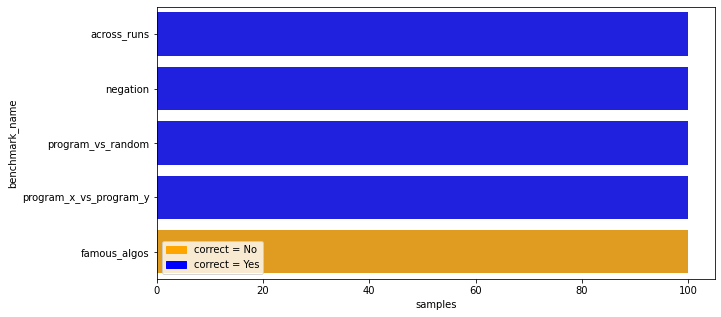

In [135]:
analyzer.classify_based_on_pvalue(treshold=0.05)
analyzer.plot_benchmark_categories()

In [136]:
analyzer.df_all.head()

,statistic,p_value,test,test_long_name,circuit_id,benchmark_name,expected_divergence,label,n_qubits,strategy_a,strategy_b,prediction_divergence,correct_prediction
0,0.413818,0.000000e+00,ks,Kolmogorov–Smirnov Test,0,program_vs_random,True,1,5,WeightedRandomCircuitGenerator,FakeCircuitGenerator,True,True
1,0.057983,2.156063e-12,ks,Kolmogorov–Smirnov Test,1,program_vs_random,True,1,10,WeightedRandomCircuitGenerator,FakeCircuitGenerator,True,True
2,0.112061,3.413783e-45,ks,Kolmogorov–Smirnov Test,2,program_vs_random,True,1,9,WeightedRandomCircuitGenerator,FakeCircuitGenerator,True,True
3,0.506104,0.000000e+00,ks,Kolmogorov–Smirnov Test,0,famous_algos,False,0,6,FamousCircuitGenerator,FamousCircuitGenerator,True,False
4,0.253784,4.455115e-232,ks,Kolmogorov–Smirnov Test,1,famous_algos,False,0,11,FamousCircuitGenerator,FamousCircuitGenerator,True,False


In [138]:
sum(analyzer.df_all["correct_prediction"])

12

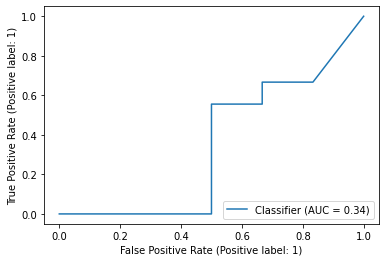

In [137]:
analyzer.plot_ROC()